In [729]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class PivotTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(
        self, 
        cell_col: str="cell_id", 
        time_col: str="time", 
        value_col: str='value',
    ):
        self.cell_col = cell_col
        self.time_col = time_col
        self.value_col = value_col
    
    def fit(self, X: pd.DataFrame, y=0):
        return self
    
    def transform(self, X: pd.DataFrame):
        return X.pivot(
            index=self.time_col, columns=self.cell_col, values=self.value_col
        )

class FloatIndexDownsampler(BaseEstimator, TransformerMixin):
    
    def __init__(
        self,
        new_interval: str,
        index_name: str = "time",
    ):
        self.new_interval = new_interval
        self.index_name = index_name
    
    def fit(self, X: pd.DataFrame, y=0):
        return self
    
    def transform(self, X: pd.DataFrame, y=0):
        X = downsample(X.reset_index(), new_interval=self.new_interval)
        X.set_index(self.index_name, inplace=True)
        return X

In [744]:
def y_from_X(df: pd.DataFrame, session_name: str, time_col: str = "time"):
    df = align_to_block(df, session_name, time_col)
    y = df["block"]
    return y

def get_pivoted_X_y(
    df: pd.DataFrame, 
    y_col: str,
    session_name: str,
    downsample_interval: str, 
    cell_col: str = "cell_id",
    time_col: str = "time",
    value_col: str = "value",
) -> Tuple[pd.DataFrame, pd.Series]:
    
    df = df[[c for c in df.columns if c != y_col]]
    pipe = Pipeline([
        ('pivot', PivotTransformer(cell_col=cell_col, time_col=time_col, value_col=value_col)),
        ('downsample', FloatIndexDownsampler(new_interval=downsample_interval, index_name="time")),
    ])
    X = pipe.fit_transform(df)
    y = y_from_X(X.reset_index(), time_col=time_col, session_name=session_name)
    return X, y

In [547]:
from spiketimes.df.binning import which_bin
from context_analysis.load import load_traces, load_mice, load_spikes, load_behaviour
from context_analysis.utils import align_to_block
from context_analysis.onep.resample import downsample
from context_analysis.onep.reshape import pivot
from context_analysis.utils import split_by_group
from typing import Tuple

In [669]:
spikes = load_spikes(experiment="pfc", session_names=["day4-test1"])
spikes = align_to_block(spikes, session_name="day4-test1")

In [670]:
dataset = spikes

# split byt group
exp, one, no = split_by_group(dataset)

In [707]:
resample_interval = "500ms"
num_splits = 10

# clf = LogisticRegression(C=25000, penalty="elasticnet", solver='saga', l1_ratio=0.2)
# clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
# clf = GradientBoostingClassifier(n_estimators=200)
pipe = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
#     ('decompose', PCA(20)),
    ("clf", clf)
])

In [708]:
X, y = get_pivoted_X_y(exp, y_col="block", session_name="day4-test1", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
# cross_val_score(pipe, X_train, y_train, cv=KFold(num_splits))

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
# cross_val_score(pipe, X_train, y_train, cv=KFold(num_splits))

C:\Users\roryl\.conda\envs\cyl\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.475

In [686]:
X, y = get_pivoted_X_y(one, y_col="block", session_name="day4-test1", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
cross_val_score(pipe, X_train, y_train, cv=KFold(num_splits))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
# cross_val_score(pipe, X_train, y_train, cv=KFold(num_splits))


0.41944444444444445

In [687]:
X, y = get_pivoted_X_y(no, y_col="block", session_name="day4-test1", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
cross_val_score(pipe, X_train, y_train, cv=KFold(num_splits))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
# cross_val_score(pipe, X_train, y_train, cv=KFold(num_splits))

0.6444444444444445

In [346]:
resample_interval = "500ms"
num_splits = 10

clf = LogisticRegression(C=0.01, penalty="elasticnet", solver='saga', l1_ratio=0.2)
pipe = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
#     ('decompose', PCA(20)),
    ("clf", clf)
])

In [350]:
res = []

In [351]:
X, y = get_pivoted_X_y(exp, y_col="block", session_name="day4-test1", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
res.append(pipe.score(X_test, y_test))

In [352]:
X, y = get_pivoted_X_y(one, y_col="block", session_name="day4-test1", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
res.append(pipe.score(X_test, y_test))

In [353]:
X, y = get_pivoted_X_y(no, y_col="block", session_name="day4-test1", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
res.append(pipe.score(X_test, y_test))

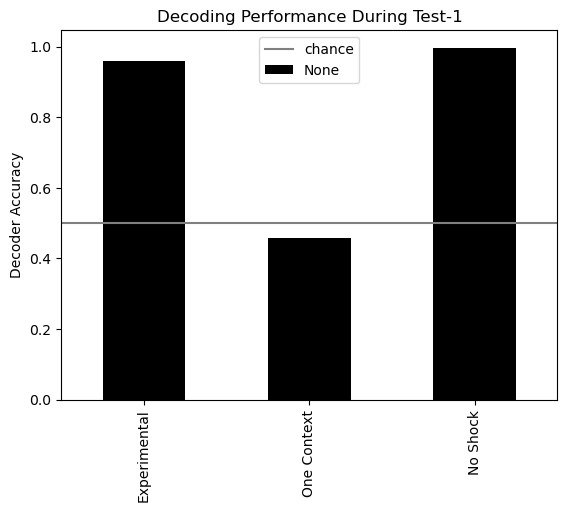

In [359]:
pd.Series(res, index=["Experimental", "One Context", "No Shock"]).plot(kind="bar", color="black")
plt.title("Decoding Performance During Test-1")
plt.ylabel("Decoder Accuracy")
plt.axhline(0.5, label="chance", color="grey")
plt.legend()
plt.show()


In [ ]:
# test2

In [720]:
traces = load_traces(experiment="pfc", session_names=["day5-test2"])
traces = align_to_block(traces, session_name="day5-test2")

In [747]:
traces = traces.loc[lambda x: x.block != "mixed"]

In [748]:
exp, one, no = split_by_group(traces)

In [761]:
resample_interval = "500ms"
num_splits = 10
res = []
clf = LogisticRegression(C=0.01, penalty="elasticnet", solver='saga', l1_ratio=0.3)
pipe = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
#     ('decompose', PCA(20)),
    ("clf", clf)
])

In [762]:
X, y = get_pivoted_X_y(exp, y_col="block", session_name="day5-test2", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

pipe.fit(X_train, y_train)
res.append(pipe.score(X_test, y_test))
pipe.score(X_test, y_test)

0.8722222222222222

In [763]:
cells = pipe["clf"].coef_.flatten()

np.mean(np.abs(cells) > 0.001)

0.24691358024691357

In [764]:
X, y = get_pivoted_X_y(one, y_col="block", session_name="day5-test2", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

pipe.fit(X_train, y_train)
res.append(pipe.score(X_test, y_test))
pipe.score(X_test, y_test)

0.5055555555555555

In [765]:
X, y = get_pivoted_X_y(no, y_col="block", session_name="day5-test2", downsample_interval=resample_interval)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

pipe.fit(X_train, y_train)
res.append(pipe.score(X_test, y_test))
pipe.score(X_test, y_test)

1.0

In [773]:
#cells 
cells = pipe["clf"].coef_.flatten()

# np.mean(np.abs(cells) > 0.001)
np.array(X.columns)[np.abs(cells) > 0.001]

array([3049, 111, 500, 3101, 3102, 2603, 2735, 1472, 1605, 864, 162, 987,
       1037, 1633, 292, 1202, 567, 744, 1028, 254, 876, 843, 601, 667,
       700, 1058, 722], dtype=object)

In [635]:
# cells = np.argsort(np.abs(pipe["clf"].coef_)).flatten()[-5:]
# sns.heatmap(X.iloc[:, cells].apply(zscore).transpose(), cmap="coolwarm", vmin=-3, vmax=3)
# plt.show()

In [636]:
cells = pipe["clf"].coef_.flatten()

np.mean(np.abs(cells) > 0.001)

0.10017574692442882

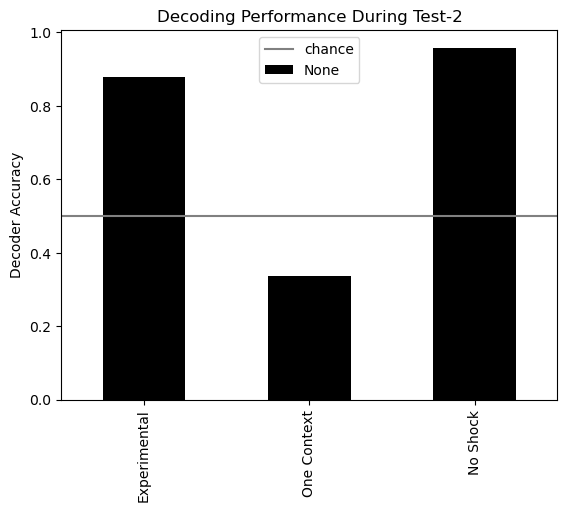

In [570]:
pd.Series(res, index=["Experimental", "One Context", "No Shock"]).plot(kind="bar", color="black")
plt.title("Decoding Performance During Test-2")
plt.ylabel("Decoder Accuracy")
plt.axhline(0.5, label="chance", color="grey")
plt.legend()
plt.show()
